#### CIFAR10 Attack Notebook

In [1]:
%%capture installation
import os
import sys
import argparse
import datetime

import numpy as np

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from typing import Callable, Tuple, Dict
from pathlib import Path
import pytorch_lightning as pl
from torch import nn

from dataloader import load_mnist
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CelebAAutoencoder, CIFAR10Autoencoder)
from models.classifier import (CelebAClassifier, CIFAR10Classifier,
                                MNISTClassifier)

from attacks import ATTACK_MAPPINGS
from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

In [5]:
class Args:
    batch_size = 10
    attack_name = "deepfool"
    device  = "mps"
    model_name = "cifar10_cnn_1"
    ae_name = "ann_128"
    plot = False
    plot_dir = "./plots"
    kwargs = {}

args = Args()

In [6]:
attack_name = ATTACK_MAPPINGS.get(args.attack_name)
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")
_, _, test_dataloader = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
print(f"Loaded dataloader!!!!!") 

Working on the dataset: cifar10!!!!!


/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded classifier and autoencoder models in eval mode!!!!!
Files already downloaded and verified
Files already downloaded and verified
Loaded dataloader!!!!!


In [8]:
x, y, z = get_xyz(args, autoencoder_model, test_dataloader)
    
config["latent_shape"] = args.ae_name.split('_')[-1]
classifier, hybrid_classifier, accuracy = hybridize(x, y, z, 
                                                    config, classifier_model, autoencoder_model)

# Perform attack
result: Dict = execute_attack(config, attack_name, x, y, z, classifier, hybrid_classifier, autoencoder_model, args.kwargs)

Accuracy on benign test examples: 100.0%
Accuracy on benign test examples(from reconstructed): 60.0%


DeepFool: 100%|██████████| 10/10 [01:15<00:00,  7.52s/it]


Accuracy on adversarial test examples: 20.0%


DeepFool: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]

Accuracy on adversarial test examples(Reconstruced X_adv): 10.0%
Accuracy on adversarial test examples(Modified): 100.0%


In [11]:
orig_attk_images = result[attack_name.__name__]["x_test_adv_np"]
modf_attk_images = result[attack_name.__name__]["xx_test_adv_np"]
hybrid_attk_images = result[attack_name.__name__]["x_hat_adv_accuracy"]

orig_attk_noise = result[attack_name.__name__]["x_test_noise"]
modf_attk_noise = result[attack_name.__name__]["xx_test_noise"]
# hybrid_attk_noise = result[attack_name.__name__]["hybrid_noise"]

import torchvision
def plot_images(images):
    plt.figure(figsize=(20, 2))
    images = torch.Tensor(images).reshape(-1, 3, 32, 32)
    # i = 1
    # for image in images:
    #     plt.subplot(5, 5, i, xticks=[], yticks=[])
    #     plt.imshow(np.transpose(image, (1, 2, 0)))
    #     i = i + 1

    #     if i == 26:
    #         break
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

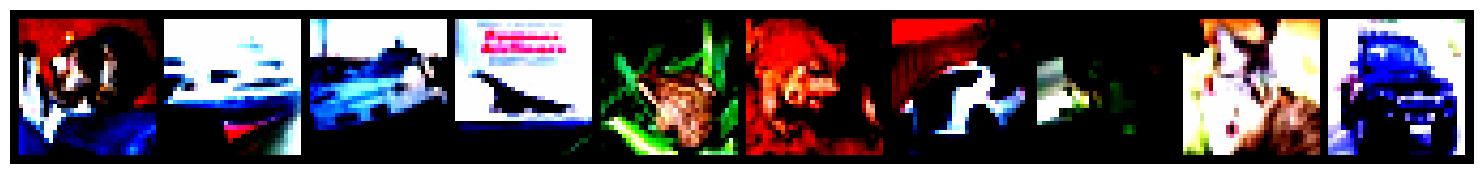

In [12]:
plot_images(orig_attk_images)

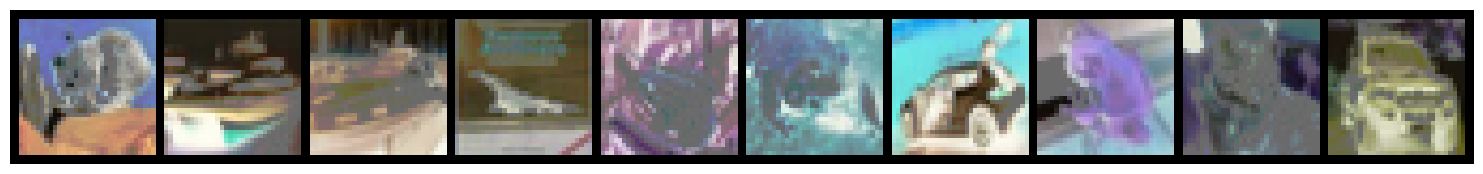

In [13]:
plot_images(orig_attk_noise)

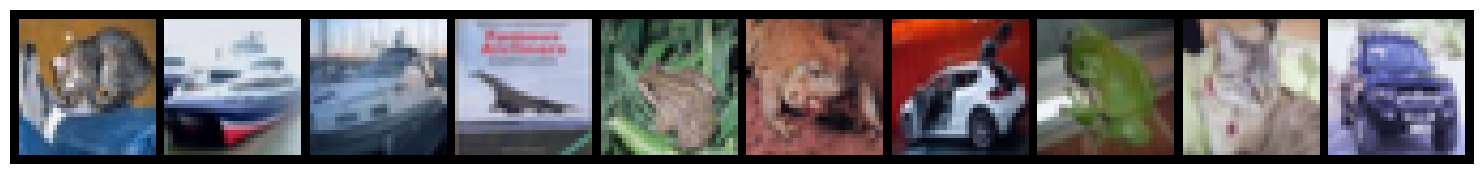

In [14]:
plot_images(x[1])

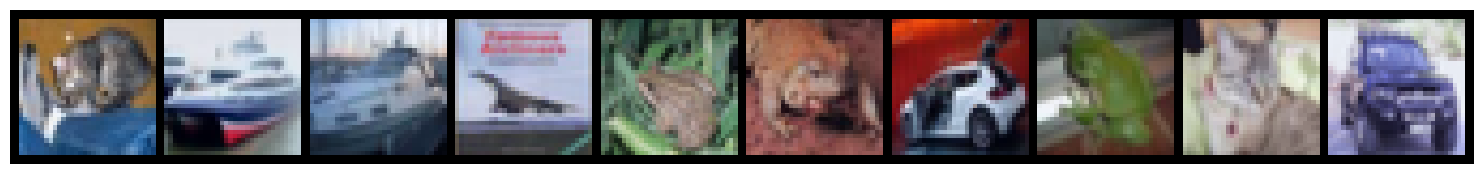

In [15]:
plot_images(modf_attk_images)

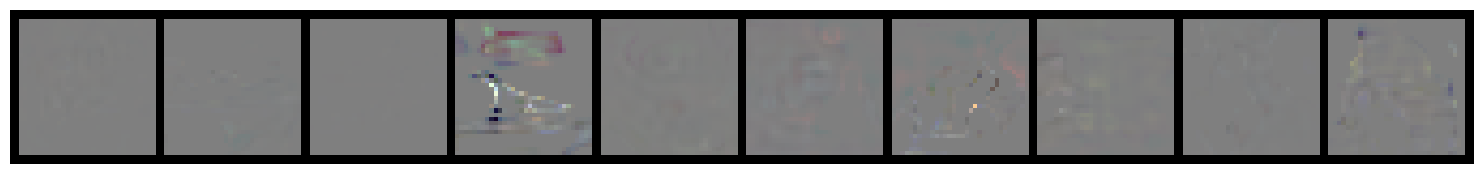

In [16]:
plot_images(modf_attk_noise)

##### LPIPS

In [17]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores

# LPIPS between original and original attacks
import torch
img0 = torch.Tensor(orig_attk_images) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = x[0].detach().cpu()
d = loss_fn_alex(img0, img1)
print(d.flatten())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
tensor([0.1225, 0.0824, 0.0768, 0.0555, 0.0994, 0.1637, 0.1594, 0.3517, 0.0549,
        0.0567], grad_fn=<ReshapeAliasBackward0>)


In [18]:
# LPIPS between original and modified attacks
import torch
img0 = torch.Tensor(modf_attk_images) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = x[0].detach().cpu()
d = loss_fn_alex(img0, img1)
print(d.flatten())

tensor([5.0942e-06, 2.7072e-05, 9.1274e-07, 3.3168e-03, 3.2934e-05, 1.3198e-04,
        5.0305e-05, 8.2677e-05, 2.8091e-05, 1.4998e-04],
       grad_fn=<ReshapeAliasBackward0>)


In [19]:
from robustbench.utils import load_model

model = load_model(model_name='Carmon2019Unlabeled', dataset='cifar10', threat_model='Linf')

In [25]:
import numpy as np
from art.estimators.classification import PyTorchClassifier

criterion = nn.CrossEntropyLoss()
classifier = PyTorchClassifier( 
    model=model,
    clip_values=(0, 1),
    loss=criterion,
    # optimizer=optimizer,
    input_shape=(32, 32),
    nb_classes=10,
)

predictions = classifier.predict(orig_attk_images)
accuracy = np.sum(np.argmax(predictions, axis=-1) == y[1]) / len(y[1])
accuracy

0.7